In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError

from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.datasets.citation import Citation
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess

from extraction.extract import *
from extraction.extractionvalues import *
from extraction.extractadjacency import getAdjacencyMatrix, distance_weight_adjacency
# from extraction.adj_data import *

from sklearn.metrics import mean_absolute_error, mean_squared_error
%load_ext tensorboard
# %tensorboard --logdir logs/fit

In [2]:
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
airportsFull = ICAOTOP10
airports = airportsFull[::]
airports.remove("LTFM")  # removing the new istanbul airport as it opened mid-2019

n_nodes = n_airports = len(airports)
start = datetime(2018, 3, 1)
end = datetime(2018, 4, 1)
timeslotLength = 60

# Run settings
batch_size = 1
epochs = 1200
patience = 100
lookback = 4
forecast_horizon = 10
multi_horizon = True

learning_rate = 0.0001
learning_rate = 0.0005
# learning_rate = 0.05

# runName = "top50MSE"
saveModel = True
loadModel = False
# modelSaveFolder = "kerasModels/"
# modelSaveLocation = modelSaveFolder + runName


Load Data

In [17]:
dataDict = generateNNdataMultiple(
    airports, timeslotLength, GNNFormat=True, start=start, end=end, disableWeather=True
)
times = list(dataDict.values())[0]["T"]


100%|██████████| 9/9 [00:00<00:00, 20.79it/s]


In [18]:
# we remove some of the most uncorrelated features
columnsToDrop = [
    "weekend",
    "winter",
    "spring",
    "summer",
    "autumn",
    "night",
    "morning",
    "afternoon",
    "planes",
]

Xlist = []
Ylist = []
for airport in airports:
    # T x F
    X = dataDict[airport]["X"].drop(columnsToDrop, axis=1).to_numpy()
    Xlist.append(X)

    Y = dataDict[airport]["Y"].iloc[:, :].to_numpy()
    Ylist.append(Y)


Xlist = np.stack(Xlist)
Ylist = np.stack(Ylist)
# N x T x F
Xarray = np.swapaxes(Xlist, 0, 1)
Yarray = np.swapaxes(Ylist, 0, 1)

# T x N x F

# Normalise over the features
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
X = (X - Xmean) / Xstd
print("X Mean Shape", Xmean.shape)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)
Y = (Y - Ymean) / Ystd
print("Y Mean Shape", Ymean.shape)

print("T x N x F: ", "Xarray =", Xarray.shape, "|", "Yarray =", Yarray.shape)

nFeatures = Xarray.shape[2]


X Mean Shape (8,)
Y Mean Shape (2,)
T x N x F:  Xarray = (744, 9, 8) | Yarray = (744, 9, 2)


Adjacencies

In [19]:
distance_adj = distance_weight_adjacency(airports, threshold=400)
flight_adj = getAdjacencyMatrix(airports, start, end, timeslotLength)

Aarray = distance_adj * 0.4 + (1 - 0.4) * flight_adj


In [20]:
train_split, val_split = 0.6, 0.25

fullLength = len(times)
train_idx = int(train_split * fullLength)
val_idx = int((val_split + train_split) * fullLength)
print(
    f"Train split: {0}:{train_idx} | Validation split: {train_idx}:{val_idx} | Test split: {val_idx}:{fullLength}"
)

# generate raw splits
Xtrain, Xval, Xtest = Xarray[0:train_idx], Xarray[train_idx:val_idx], Xarray[val_idx::]
Ytrain, Yval, Ytest = Yarray[0:train_idx], Yarray[train_idx:val_idx], Yarray[val_idx::]
Atrain, Aval, Atest = Aarray[0:train_idx], Aarray[train_idx:val_idx], Aarray[val_idx::]

# Save test timeslots for plotting purposes
testTimes = times.iloc[val_idx::, 0].tolist()

print("Train arrays len:", len(Xtrain), len(Ytrain), len(Atrain))


Train split: 0:446 | Validation split: 446:632 | Test split: 632:744
Train arrays len: 446 446 446


TF dataset

In [21]:
def create_tf_dataset(
    features_Array: np.ndarray,
    adjacencies_Array: np.ndarray,
    target_array,
    lookback: int,
    forecast_horizon: int,
    batch_size: int = 128,
    multi_horizon=False,
):

    X_in = timeseries_dataset_from_array(
        features_Array[:-forecast_horizon],
        None,
        sequence_length=lookback,
        shuffle=False,
        batch_size=batch_size,
    )
    A_in = timeseries_dataset_from_array(
        adjacencies_Array[:-forecast_horizon],
        None,
        sequence_length=lookback,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = lookback if multi_horizon else lookback + forecast_horizon - 1
    target_seq_length = forecast_horizon if multi_horizon else 1
   
    targets = timeseries_dataset_from_array(
        target_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )
    # dataset = tf.data.Dataset.zip((X_in, A_in))
    dataset = tf.data.Dataset.zip(((X_in, A_in), targets))
    return dataset.prefetch(16).cache()


train_dataset = create_tf_dataset(
    Xtrain,
    Atrain,
    Ytrain,
    lookback,
    forecast_horizon,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
)

val_dataset = create_tf_dataset(
    Xval,
    Aval,
    Yval,
    lookback,
    forecast_horizon,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
)
test_dataset = create_tf_dataset(
    Xtest,
    Atest,
    Ytest,
    lookback,
    forecast_horizon,
    batch_size=batch_size,
    multi_horizon=multi_horizon,
)

print(train_dataset)


<CacheDataset shapes: (((None, None, 9, 8), (None, None, 9, 9)), (None, None, 9, 2)), types: ((tf.float64, tf.float64), tf.float64)>


Model

In [22]:
# lookback = 8 # steps
l2_reg = 2.5e-4  # L2 regularization rate
# learning_rate = 2e-4  # Learning rate

channels = 10
attn_heads = 2
lstm_units = 20

num_labels = 2


In [23]:
x_in = layers.Input(shape=(lookback, n_nodes, nFeatures), batch_size=batch_size, name="Features")
a_in = layers.Input(shape=(lookback, n_nodes, n_nodes), batch_size=batch_size, name="Adjacencies")

# print(x_in.shape)
branch_outputs = []
print(f"Lookback = {lookback}")
for i in range(lookback):
    Xindividual = layers.Lambda(lambda x: x[:, i], name=f"X_{i}")(x_in)
    Aindividual = layers.Lambda(lambda x: x[:, i], name=f"A_{i}")(a_in)
    out = GATConv(
        channels=channels,
        attn_heads=attn_heads,
        kernel_regularizer=l2(l2_reg),
        attn_kernel_regularizer=l2(l2_reg),
        bias_regularizer=l2(l2_reg),
        name=f"GAT_{i}"
    )([Xindividual, Aindividual])

    branch_outputs.append(out)
    # print(out.shape)


print(Xindividual.shape)
print(Aindividual.shape)
concat = layers.Concatenate()(branch_outputs)
print(concat.shape)
reshape1 = tf.reshape(concat, (batch_size, n_nodes, channels * attn_heads, lookback), name="Reshape1")
print(reshape1.shape)
reshape2 = tf.reshape(reshape1, (batch_size * n_nodes, channels * attn_heads, lookback), name="Reshape2")
reshape2 = tf.transpose(reshape2, [0, 2, 1], name="TransposetoLSTM")
print(reshape2.shape)

lstm1 = layers.LSTM(lstm_units, return_sequences=True, name="LSTM1")(reshape2)
lstm2 = layers.LSTM(lstm_units, return_sequences=False, name="LSTM2")(lstm1)
print(lstm2.shape)
dense1 = layers.Dense(lstm_units, name="Dense1")(lstm2)
print(dense1.shape)
dense2 = layers.Dense(num_labels * forecast_horizon, name="DenseFinal")(dense1)
print(dense2.shape)

output = tf.reshape(dense2, (n_nodes, batch_size, forecast_horizon, num_labels), name="ReshapeFinal")
print(output.shape)
output = tf.transpose(output, [1, 2, 0, 3], name="Re-orderToOutput")
print(output.shape)



# # Test 
# print("hello")
# output2 = layers.Dense(128)(reshape1)
# print(output2.shape)
# output2 = layers.Dense(1)(output2)
# print(output2.shape)
# output = tf.reshape(output2, (n_nodes, batch_size, forecast_horizon, num_labels), name="ReshapeFinal")
# print(output.shape)
# output = tf.transpose(output, [1, 2, 0, 3], name="Re-orderToOutput")
# print(output.shape)

Lookback = 4
(1, 9, 8)
(1, 9, 9)
(1, 9, 80)
(1, 9, 20, 4)
(9, 4, 20)
(9, 20)
(9, 20)
(9, 20)
(9, 1, 10, 2)
(1, 10, 9, 2)


In [24]:
model = keras.Model(inputs=[x_in, a_in], outputs=output, name="Tristan")

optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_absolute_error"),
    weighted_metrics=["acc"],
)

model.summary()
# plot_model(model, to_file='model.png')

Model: "Tristan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(1, 4, 9, 8)]       0           []                               
                                                                                                  
 Adjacencies (InputLayer)       [(1, 4, 9, 9)]       0           []                               
                                                                                                  
 X_0 (Lambda)                   (1, 9, 8)            0           ['Features[0][0]']               
                                                                                                  
 A_0 (Lambda)                   (1, 9, 9)            0           ['Adjacencies[0][0]']            
                                                                                            

In [29]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1
)

print(train_dataset.element_spec)

history = model.fit(
    # x = [train_dataset[0], train_dataset[1]],
    # y = train_dataset[2],
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=patience),
        tensorboard_callback,
    ],
)

((TensorSpec(shape=(None, None, 9, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 9, 9), dtype=tf.float64, name=None)), TensorSpec(shape=(None, None, 9, 2), dtype=tf.float64, name=None))
Epoch 1/50
433/433 [==============================] - 14s 31ms/step - loss: 70.1064 - acc: 0.6024 - val_loss: 53.4714 - val_acc: 0.5714
Epoch 2/50
433/433 [==============================] - 12s 28ms/step - loss: 70.1672 - acc: 0.6024 - val_loss: 53.4520 - val_acc: 0.5714
Epoch 3/50
433/433 [==============================] - 9s 22ms/step - loss: 70.0848 - acc: 0.6024 - val_loss: 52.6452 - val_acc: 0.5714
Epoch 4/50
433/433 [==============================] - 8s 18ms/step - loss: 70.0875 - acc: 0.6024 - val_loss: 53.5567 - val_acc: 0.5714
Epoch 5/50
433/433 [==============================] - 9s 20ms/step - loss: 69.8214 - acc: 0.6024 - val_loss: 52.8589 - val_acc: 0.5714
Epoch 6/50
433/433 [==============================] - 8s 19ms/step - loss: 69.8781 - acc: 0.6024 - val_loss: 52.7355 - 

# Analysis


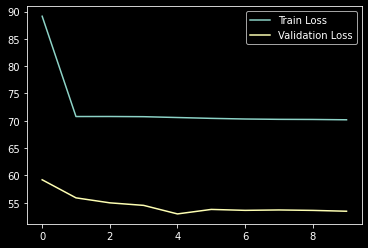

In [26]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [27]:
windowSize = 100 # 1-400
hour = 10 # 1-10
hour = min(hour, forecast_horizon)
print(f"Hours ahead = {hour}")


Hours ahead = 10


In [28]:
def getLabelArrays(hour, input_sequence_length=lookback):
    syncindex = input_sequence_length + hour - 1
    yTestPred = model.predict(test_dataset, verbose=0)
    ypredFull = yTestPred[:windowSize, hour - 1, :, :]
    yactualFull = Ytest[syncindex : windowSize + syncindex :, :]

    mae1 = mean_absolute_error(ypredFull[:, :, 0], yactualFull[:, :, 0])
    mae2 = mean_absolute_error(ypredFull[:, :, 1], yactualFull[:, :, 1])

    time = testTimes[syncindex : windowSize + syncindex :]
    return ypredFull, yactualFull, mae1, mae2, time


def plotComparison(airport_index, hour):
    ypredFull, yactualFull, _, _, time = getLabelArrays(hour)
    fig, axs = plt.subplots(2, 1, sharex=True, num=airport_index)
    axs[0].plot(
        time, yactualFull[:, 0 + airport_index, 0], label="Actual Arrival Delay"
    )
    axs[1].plot(time, yactualFull[:, airport_index, 1], label="Actual Departure Delay")
    axs[0].plot(
        time, ypredFull[:, 0 + airport_index, 0], label="Predicted Arrival Delay"
    )
    axs[1].plot(time, ypredFull[:, airport_index, 1], label="Predicted Departure Delay")
    axs[0].legend()
    # axs[1].legend()
    axs[1].set_xlabel("Time (hours)")
    axs[0].set_ylabel("Arrival Delay (mins)")
    axs[1].set_ylabel("Departure Delay (mins)")
    plt.suptitle(
        f"Comparison for: {airports[airport_index]}. Forward: {hour}h, Backward: {lookback}h"
    )
    axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M"))
    plt.xticks(rotation=45)


def plotMAEOverTime(forecast_horizon=forecast_horizon):
    hours = list(range(1, forecast_horizon + 1))
    maeList = []
    maeList2 = []
    for h in hours:
        _, _, mae1, mae2, _ = getLabelArrays(h)
        maeList.append(mae1)
        maeList2.append(mae2)
    plt.plot(hours, maeList)
    plt.plot(hours, maeList2)
    plt.xlabel("Look forward (hours)")
    plt.ylabel("MAE (minutes)")


plotMAEOverTime()
plt.show()

for airportidx in range(0, len(airports)):
    plotComparison(airportidx, hour)
# plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [99, 100]